# AUUUGH MACHINE LEARNING CLASS PART DEUX
**This notebook created by Reed Abraham**

## Imports

In [1]:
import mxnet as mx
from mxnet import autograd, gluon, np, npx
from mxnet.gluon import nn


import sys
import os
from os.path import dirname
sys.path.append(dirname("M:\\git\\d2l-en"))
from d2l import mxnet as d2l

from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np

npx.set_np()

## Dataloading

Modified family of dataloaders based on "split_and_load_ml100k" to do a few interesting things:
* Replaced unique user ID and book id with sequential integer identifiers to meet the existing algorithm.
* overall array is a user by book id matrix of "ubyte" because my computer doesn't have 108GB of memory

In [2]:
def read_data_books():
    data_dir = "M:\\git\\ML2_2021\\data"
    names = ['user_id', 'isbn', 'rating']
    data = pd.read_csv(os.path.join(data_dir, 'book_ratings.csv'), ',', names=names,
                       engine='python', skiprows=1)

    data['isbn'] = data.isbn.astype('category')
    data['book_id'] = data['isbn'].cat.codes

    data['user_id'], _ = pd.factorize(data['user_id'])
    data['book_id'], _ = pd.factorize(data['book_id'])

    data.user_id = data.user_id + 1
    data.book_id = data.book_id + 1
    
    data.drop('isbn',axis=1,inplace=True)
    data = data[['user_id','book_id','rating']]
    
    data['rating'] = data['rating'].astype(float)

    num_users = data.user_id.unique().shape[0]
    num_items = data.book_id.unique().shape[0]
    return data, num_users, num_items

In [3]:
data,nu,ni=read_data_books()

C:\Users\ARICK_~1\AppData\Local\Temp/ipykernel_129760/2596294887.py:1: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only
  data,nu,ni=read_data_books()


In [4]:
# Defined in file: ./chapter_recommender-systems/movielens.md
def split_data_books(data, num_users, num_items, split_mode='serial',
                      test_ratio=0.2):
    """Split the dataset in random mode or seq-aware mode."""
    if split_mode == 'seq-aware':
        train_items, test_items, train_list = {}, {}, []
        for line in data.itertuples():
            u, i, rating = line[1], line[2], line[3]
            train_items.setdefault(u, []).append((u, i, rating))
            if u not in test_items:
                test_items[u] = (i, rating)
        for u in range(1, num_users + 1):
            train_list.extend(sorted(train_items[u], key=lambda k: k[2]))
        test_data = [(key, *value) for key, value in test_items.items()]
        train_data = [item for item in train_list if item not in test_data]
        train_data = pd.DataFrame(train_data)
        test_data = pd.DataFrame(test_data)
    elif split_mode == "serial":
        train_data, test_data = train_test_split(data, test_size=test_ratio, shuffle=False)
    else:
        mask = [
            True if x == 1 else False
            for x in np.random.uniform(0, 1, (len(data))) < 1 - test_ratio]
        neg_mask = [not x for x in mask]
        train_data, test_data = data[mask], data[neg_mask]
    return train_data, test_data

# Defined in file: ./chapter_recommender-systems/movielens.md
def load_data_books(data, num_users, num_items, feedback='explicit'):
    users, items, scores = [], [], []
    inter = []
    # inter = np.zeros((num_items, num_users),dtype=np.half) if feedback == 'explicit' else {}
    for line in data.itertuples():
        user_index, item_index = int(line[1] - 1), int(line[2] - 1)
        score = int(line[3]) if feedback == 'explicit' else 1
        users.append(user_index)
        items.append(item_index)
        scores.append(score)
        if feedback == 'implicit':
            inter.setdefault(user_index, []).append(item_index)
        else:
            # inter[item_index, user_index] = score
            pass
    return users, items, scores, inter


# Defined in file: ./chapter_recommender-systems/movielens.md
def split_and_load_books(split_mode='serial', feedback='explicit',
                          test_ratio=0.1, batch_size=256):
    data, num_users, num_items = read_data_books()
    train_data, test_data = split_data_books(data, num_users, num_items,
                                              split_mode, test_ratio)
    train_u, train_i, train_r, _ = load_data_books(train_data, num_users,
                                                    num_items, feedback)
    test_u, test_i, test_r, _ = load_data_books(test_data, num_users,
                                                 num_items, feedback)
    train_set = gluon.data.ArrayDataset(np.array(train_u), np.array(train_i),
                                        np.array(train_r,dtype=float))
    test_set = gluon.data.ArrayDataset(np.array(test_u), np.array(test_i),
                                       np.array(test_r,dtype=float))
    train_iter = gluon.data.DataLoader(train_set, shuffle=True,
                                       last_batch='rollover',
                                       batch_size=batch_size)
    test_iter = gluon.data.DataLoader(test_set, batch_size=batch_size)
    return num_users, num_items, train_iter, test_iter

In [5]:
num_users, num_items, train_iter, test_iter = split_and_load_books(
    test_ratio=0.2, batch_size=2048)

C:\Users\ARICK_~1\AppData\Local\Temp/ipykernel_129760/2123351042.py:50: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only
  data, num_users, num_items = read_data_books()


In [6]:
train_iter

## Training + Algorithm Code

In [7]:
class MF_alfa(nn.Block):
    def __init__(self, num_factors, num_users, num_items, **kwargs):
        super(MF_alfa, self).__init__(**kwargs)
        self.P = nn.Embedding(input_dim=num_users, output_dim=num_factors)
        self.Q = nn.Embedding(input_dim=num_items, output_dim=num_factors)

    def forward(self, user_id, item_id):
        P_u = self.P(user_id)
        Q_i = self.Q(item_id)
        outputs = (P_u * Q_i).sum(axis=1)
        return outputs.flatten()

class MF_alfa_user(nn.Block):
    def __init__(self, num_factors, num_users, num_items, **kwargs):
        super(MF_alfa_user, self).__init__(**kwargs)
        self.P = nn.Embedding(input_dim=num_users, output_dim=num_factors)
        self.Q = nn.Embedding(input_dim=num_items, output_dim=num_factors)
        self.user_bias = nn.Embedding(num_users, 1)

    def forward(self, user_id, item_id):
        P_u = self.P(user_id)
        Q_i = self.Q(item_id)
        b_u = self.user_bias(user_id)
        outputs = (P_u * Q_i).sum(axis=1) + np.squeeze(b_u)
        return outputs.flatten()

class MF_alfa_item(nn.Block):
    def __init__(self, num_factors, num_users, num_items, **kwargs):
        super(MF_alfa_item, self).__init__(**kwargs)
        self.P = nn.Embedding(input_dim=num_users, output_dim=num_factors)
        self.Q = nn.Embedding(input_dim=num_items, output_dim=num_factors)
        self.item_bias = nn.Embedding(num_items, 1)

    def forward(self, user_id, item_id):
        P_u = self.P(user_id)
        Q_i = self.Q(item_id)
        b_i = self.item_bias(item_id)
        outputs = (P_u * Q_i).sum(axis=1) + np.squeeze(b_i)
        return outputs.flatten()

class MF(nn.Block):
    def __init__(self, num_factors, num_users, num_items, **kwargs):
        super(MF, self).__init__(**kwargs)
        self.P = nn.Embedding(input_dim=num_users, output_dim=num_factors)
        self.Q = nn.Embedding(input_dim=num_items, output_dim=num_factors)
        self.user_bias = nn.Embedding(num_users, 1)
        self.item_bias = nn.Embedding(num_items, 1)

    def forward(self, user_id, item_id):
        P_u = self.P(user_id)
        Q_i = self.Q(item_id)
        b_u = self.user_bias(user_id)
        b_i = self.item_bias(item_id)
        outputs = (P_u * Q_i).sum(axis=1) + np.squeeze(b_u) + np.squeeze(b_i)
        return outputs.flatten()

In [22]:
def local_evaluator(net, test_iter, devices):
    rmse = mx.metric.RMSE()  # Get the RMSE
    rmse_list = []
    for idx, (users, items, ratings) in enumerate(test_iter):
        u = gluon.utils.split_and_load(users, devices, even_split=False)
        i = gluon.utils.split_and_load(items, devices, even_split=False)
        r_ui = gluon.utils.split_and_load(ratings, devices, even_split=False)
        r_hat = [net(u, i) for u, i in zip(u, i)]
        rmse.update(labels=r_ui, preds=r_hat)
        rmse_list.append(rmse.get()[1])
    return float(np.mean(np.array(rmse_list)))

In [23]:
#@save
def train_recsys_rating(net, train_iter, test_iter, loss, trainer, num_epochs,
                        devices=d2l.try_all_gpus(), evaluator=None, **kwargs):
    timer = d2l.Timer()
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0, 25],
                            legend=['train loss', 'test RMSE'])
    for epoch in range(num_epochs):
        # print("Commencing Epoch: {}".format(epoch))

        metric, l = d2l.Accumulator(3), 0.
        for i, values in enumerate(train_iter):
            timer.start()
            input_data = []
            values = values if isinstance(values, list) else [values]
            for v in values:
                input_data.append(gluon.utils.split_and_load(v, devices))
            train_feat = input_data[0:-1] if len(values) > 1 else input_data
            train_label = input_data[-1]
            with autograd.record():
                preds = [net(*t) for t in zip(*train_feat)]
                ls = [loss(p, s) for p, s in zip(preds, train_label)]
            [l.backward() for l in ls]
            l += sum([l.asnumpy() for l in ls]).mean() / len(devices)
            trainer.step(values[0].shape[0])
            metric.add(l, values[0].shape[0], values[0].size)
            timer.stop()
        if len(kwargs) > 0:  # It will be used in section AutoRec
            test_rmse = local_evaluator(net, test_iter, kwargs['inter_mat'],
                                  devices)
        else:
            test_rmse = local_evaluator(net, test_iter, devices)
        train_l = l / (i + 1)
        animator.add(epoch + 1, (train_l, test_rmse))
        # print("Finished Epoch {} with loss value {} and RMSE {}".format(epoch, train_l, test_rmse))
    print(f'train loss {metric[0] / metric[1]:.3f}, '
          f'test RMSE {test_rmse:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec '
          f'on {str(devices)}')

## Execution Code

### Alpha Only

train loss 0.127, test RMSE 7.837
536946.2 examples/sec on [cpu(0)]


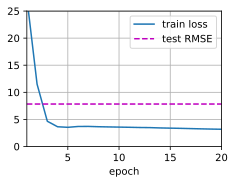

In [24]:
devices = d2l.try_all_gpus()
num_users, num_items, train_iter, test_iter = split_and_load_books(
    test_ratio=0.2, batch_size=2048)
net = MF_alfa(50, num_users, num_items)
net.initialize(ctx=devices, force_reinit=True, init=mx.init.Normal(0.01))
lr, num_epochs, wd, optimizer = 0.02, 20, 1e-5, 'adam'
loss = gluon.loss.L2Loss()
trainer = gluon.Trainer(net.collect_params(), optimizer, {
    "learning_rate": lr,
    'wd': wd})
train_recsys_rating(net, train_iter, test_iter, loss, trainer, num_epochs,
                    devices, local_evaluator)

### Alpha + User

In [ ]:
devices = d2l.try_all_gpus()
num_users, num_items, train_iter, test_iter = split_and_load_books(
    test_ratio=0.2, batch_size=2048)
net = MF_alfa_user(100, num_users, num_items)
net.initialize(ctx=devices, force_reinit=True, init=mx.init.Normal(0.01))
lr, num_epochs, wd, optimizer = 0.02, 20, 1e-5, 'adam'
loss = gluon.loss.L2Loss()
trainer = gluon.Trainer(net.collect_params(), optimizer, {
    "learning_rate": lr,
    'wd': wd})
train_recsys_rating(net, train_iter, test_iter, loss, trainer, num_epochs,
                    devices, local_evaluator)

### Alpha + Item

In [ ]:
devices = d2l.try_all_gpus()
num_users, num_items, train_iter, test_iter = split_and_load_books(
    test_ratio=0.2, batch_size=2048)
net = MF_alfa_item(100, num_users, num_items)
net.initialize(ctx=devices, force_reinit=True, init=mx.init.Normal(0.01))
lr, num_epochs, wd, optimizer = 0.02, 20, 1e-5, 'adam'
loss = gluon.loss.L2Loss()
trainer = gluon.Trainer(net.collect_params(), optimizer, {
    "learning_rate": lr,
    'wd': wd})
train_recsys_rating(net, train_iter, test_iter, loss, trainer, num_epochs,
                    devices, local_evaluator)

### All Params

In [ ]:
devices = d2l.try_all_gpus()
num_users, num_items, train_iter, test_iter = split_and_load_books(
    test_ratio=0.2, batch_size=2048)
net = MF(100, num_users, num_items)
net.initialize(ctx=devices, force_reinit=True, init=mx.init.Normal(0.01))
lr, num_epochs, wd, optimizer = 0.02, 20, 1e-5, 'adam'
loss = gluon.loss.L2Loss()
trainer = gluon.Trainer(net.collect_params(), optimizer, {
    "learning_rate": lr,
    'wd': wd})
train_recsys_rating(net, train_iter, test_iter, loss, trainer, num_epochs,
                    devices, local_evaluator)

In [ ]:
scores = net(np.array([20], dtype='int', ctx=devices[0]),
             np.array([30], dtype='int', ctx=devices[0]))
scores